# The impact of weather conditions on cycling counts in Auckland, New Zealand 

## Introduction 

This Jupyter notebook presents an analysis of cycling counts along a busy cycle path (Tamaki Drive, in Auckland central) in Auckland, New Zealand, and examines how weather conditions (rainfall, temperature, wind, sunshine fraction) influence the number of cyclists on a day to day basis.   

It makes use of the [fbprophet](https://facebook.github.io/prophet/) library. fbprophet implements a [Generalized Additive Model](https://en.wikipedia.org/wiki/Generalized_additive_model), which can model a time-series as the sum of different components (non-linear trend, periodic components and holidays or special events) and allows to incorporate extra-regressors (categorical or continuous). 

In this notebook, we first explore some characteristics of the hourly and daily cycling counts over Tamaki drive, then build a model first without, then with the weather extra-regressors. 

The cycling counts data (initially available at the hourly interval) are provided by [Auckland Transport](https://at.govt.nz/) (see [the Auckland Transport cyclong and walking research and monitoring website](https://at.govt.nz/cycling-walking/research-monitoring/)) and the hourly weather data are provided by the [National Institute for Water and Atmospheric research](http://www.niwa.co.nz) (NIWA Ltd) [CliFlo](https://cliflo.niwa.co.nz/) database. 



### imports and settings 

#### disable the sdout logging of fbprophet 

In [76]:
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
import os
import sys
from glob import glob 

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [5]:
from calendar import day_abbr

In [6]:
import holidays

In [7]:
from fbprophet import Prophet

In [8]:
from sklearn.metrics import mean_absolute_error as MAE

In [9]:
import seaborn as sns

In [10]:
from scipy.stats import skew, skewtest

####  fbprophet

In [77]:
import fbprophet

In [78]:
fbprophet.__version__

'0.3'

In [79]:
Prophet = fbprophet.Prophet

In [108]:
sys.path.append('../code/')

In [111]:
import utils

### reads the counter locations 

we read the counters locations, and display these locations on an interactive map powered by [Folium]()

In [97]:
import folium
from folium.plugins import MarkerCluster

In [83]:
loc_counters = pd.read_csv('../data/cycling_Auckland/cycling_counters.csv')

In [84]:
loc_counters = loc_counters.query("user_type == 'Cyclists'")

In [89]:
loc_counters.loc[loc_counters.name.str.contains("Tamaki"),:]

,name,id,Name.1,latitude,longitude,site_code,setup_date,user_type
44,Tamaki Drive EB,100000827,Tamaki Drive EB,-36.847782,174.78935,ECO08011685,12/11/2009,Cyclists
45,Tamaki Drive WB,100003810,Tamaki Drive WB,-36.847942,174.78903,U15G2011813,26/03/2012,Cyclists


In [90]:
center_lat = loc_counters.query("name == 'Tamaki Drive EB'").latitude.values[0]
center_lon = loc_counters.query("name == 'Tamaki Drive EB'").longitude.values[0]

In [116]:
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=14,
    tiles='OpenStreetMap', 
    width='80%', 
)

m.add_child(folium.LatLngPopup())

marker_cluster = MarkerCluster().add_to(m)

for i, row in loc_counters.iterrows():
    name = row['name']
    lat = row.latitude
    lon = row.longitude
    opened = row.setup_date
    
    # HTML here in the pop up 
    popup = '<b>{}</b></br><i>setup date = {}</i>'.format(name, opened)
    
    folium.Marker([lat, lon], popup=popup, tooltip=name).add_to(marker_cluster)

In [117]:
m

### read the actual counter data, and extract the time-series for the Tamaki drive counters 

In [100]:
lfiles = glob('../data/cycling_Auckland/cycling_counts_????.csv')

In [101]:
lfiles.sort()

In [102]:
l = []
for f in lfiles: 
    d = pd.read_csv(f, index_col=0, parse_dates=True)
    l.append(d)

In [103]:
df = pd.concat(l, axis=0)

In [104]:
df = df.loc[:,['Tamaki Drive EB', 'Tamaki Drive WB']]

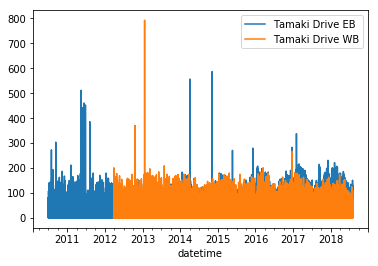

In [105]:
df.plot()

there seems to be a few pretty large outliers, we're going to try and filter these out

### adds Tamaki drive eastern bound and western bound together 

In [106]:
Tamaki = df.loc[:,'Tamaki Drive WB'] +  df.loc[:,'Tamaki Drive EB']

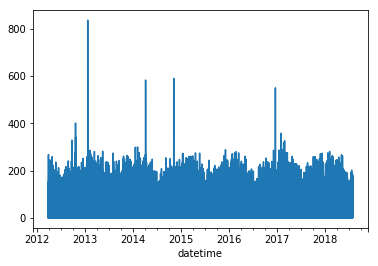

In [107]:
Tamaki.plot()

### restrict to the period where the hourly weather data is available 

In [22]:
Tamaki = Tamaki.loc['2013':'2018-06-01',]

In [23]:
Tamaki = Tamaki.to_frame(name='Tamaki Drive')

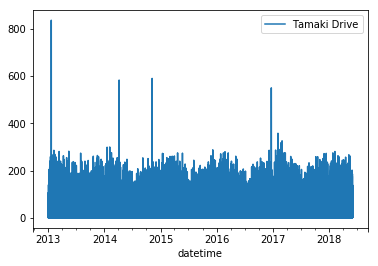

In [24]:
Tamaki.plot()

### getting rid of the outliers using a median filter 

In [113]:
utils.median_filter?

Signature: utils.median_filter(df, varname='Tamaki Drive', window=24, std=3)
Docstring: <no docstring>
File:      ~/research/NIWA/Auckland_Cycling/code/utils.py
Type:      function


In [26]:
dfc = Tamaki.copy()

In [27]:
dfc.loc[:,'Tamaki Drive, Filtered'] = utils.median_filter(dfc)

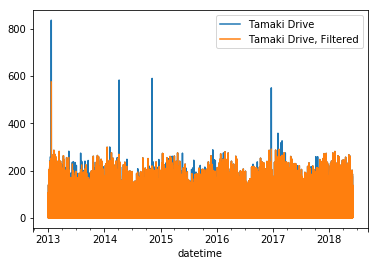

In [28]:
dfc.plot()

### plots the seasonal cycle 

In [30]:
seas_cycl = dfc.loc[:,'Tamaki Drive, Filtered'].rolling(window=30*24, center=True, min_periods=20).mean().groupby(dfc.index.dayofyear).mean()

In [31]:
q25 = dfc.loc[:,'Tamaki Drive, Filtered'].rolling(window=30*24, center=True, min_periods=20).mean().groupby(dfc.index.dayofyear).quantile(0.25)
q75 = dfc.loc[:,'Tamaki Drive, Filtered'].rolling(window=30*24, center=True, min_periods=20).mean().groupby(dfc.index.dayofyear).quantile(0.75)

In [32]:
from calendar import mdays, month_abbr

In [33]:
ndays_m = mdays.copy()

In [34]:
ndays_m[2] = 29

In [35]:
ndays_m = np.cumsum(ndays_m)

In [36]:
month_abbr = month_abbr[1:]

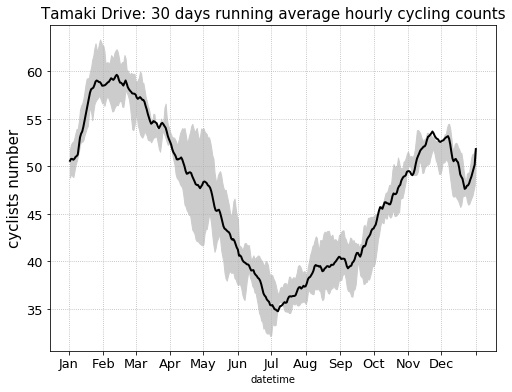

In [37]:
f, ax = plt.subplots(figsize=(8,6)) 

seas_cycl.plot(ax=ax, lw=2, color='k', legend=False)

ax.fill_between(seas_cycl.index, q25.values.ravel(), q75.values.ravel(), color='0.8')

ax.set_xticks(ndays_m)
ax.set_xticklabels(month_abbr)

ax.grid(ls=':')

# ax.set_xlabel('day of the year', fontsize=15)

ax.set_ylabel('cyclists number', fontsize=15);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('Tamaki Drive: 30 days running average hourly cycling counts', fontsize=15)

f.savefig('../figures/paper/seasonal_cycle.png', dpi=200)
f.savefig('../figures/paper/seasonal_cycle.jpeg', dpi=200)
f.savefig('../figures/paper/seasonal_cycle.pdf')

### cyclists per day of week and hour of the day 

In [38]:
hour_week = dfc.loc[:,['Tamaki Drive, Filtered']].copy()

In [39]:
hour_week.loc[:,'day_of_week'] = hour_week.index.dayofweek
hour_week.loc[:,'hour'] = hour_week.index.hour

In [40]:
hour_week = hour_week.groupby(['day_of_week','hour']).mean().unstack()

In [41]:
hour_week.columns = hour_week.columns.droplevel(0)

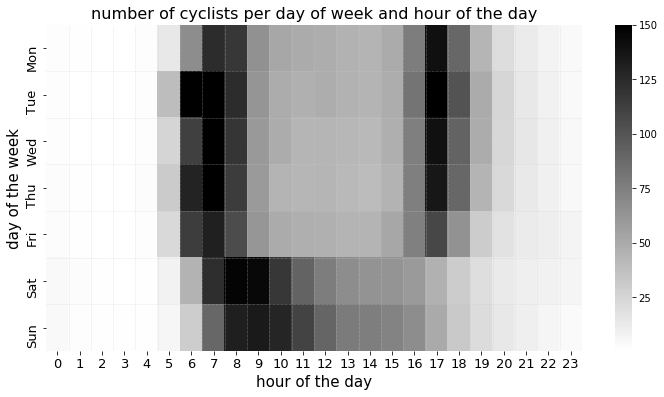

In [42]:
f, ax = plt.subplots(figsize=(12,6))
sns.heatmap(hour_week, ax = ax, cmap=plt.cm.gray_r, vmax=150)

[ax.axhline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 7)]
[ax.axvline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 24)];

ax.set_title('number of cyclists per day of week and hour of the day', fontsize=16)

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('hour of the day', fontsize=15)
ax.set_ylabel('day of the week', fontsize=15)
ax.set_yticklabels(day_abbr[0:7]);

f.savefig('../figures/paper/cyclists_dayofweek_hourofday.png', dpi=200)
f.savefig('../figures/paper/cyclists_dayofweek_hourofday.jpeg', dpi=200)
f.savefig('../figures/paper/cyclists_dayofweek_hourofday.pdf')


In [43]:
summary_hour = Tamaki.groupby(Tamaki.index.hour).describe()

In [44]:
summary_hour.columns = summary_hour.columns.droplevel(0)

### looking at week days versus week-ends 

In [45]:
weekdays = Tamaki.loc[Tamaki.index.weekday_name.isin(['Monday','Tuesday','Wednesday','Thursday','Friday'])]
weekends = Tamaki.loc[Tamaki.index.weekday_name.isin(['Sunday','Saturday'])]

In [46]:
summary_hour_weekdays = weekdays.groupby(weekdays.index.hour).describe()
summary_hour_weekends = weekends.groupby(weekends.index.hour).describe()

In [47]:
summary_hour_weekdays.columns = summary_hour_weekdays.columns.droplevel(0)

In [48]:
summary_hour_weekends.columns = summary_hour_weekends.columns.droplevel(0)

### black and white version

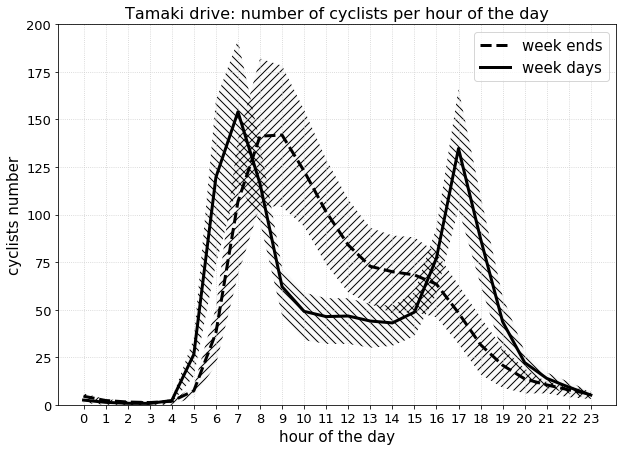

In [49]:
f, ax = plt.subplots(figsize=(10,7))

ax.plot(summary_hour_weekends.index, summary_hour_weekends.loc[:,'mean'], color='k', label='week ends', ls='--', lw=3)

ax.fill_between(summary_hour_weekends.index, summary_hour_weekends.loc[:,'25%'], \
                summary_hour_weekends.loc[:,'75%'], hatch='///', facecolor='0.8', alpha=0.1)

ax.set_xticks(range(24));

ax.grid(ls=':', color='0.8')

# ax.set_title('week-ends', fontsize=16)

ax.plot(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,'mean'], color='k', label='week days', lw=3)

ax.fill_between(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,'25%'], \
                summary_hour_weekdays.loc[:,'75%'], hatch='\\\\\\', facecolor='0.8', alpha=0.1)

ax.legend(loc=1 , fontsize=15)

ax.set_xticks(range(24));

ax.grid(ls=':', color='0.8')

ax.set_ylim([0, 200])

ax.set_xlabel('hour of the day', fontsize=15)

ax.set_ylabel('cyclists number', fontsize=15);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('Tamaki drive: number of cyclists per hour of the day', fontsize=16)

f.savefig('../figures/paper/daily_cycle.png', dpi=200)
f.savefig('../figures/paper/daily_cycle.jpeg', dpi=200)
f.savefig('../figures/paper/daily_cycle.pdf')

### calculates the daily totals from the hourly data 

In [54]:
data = dfc.loc['2013':,['Tamaki Drive, Filtered']].resample('1D').sum()

### plots the time series 

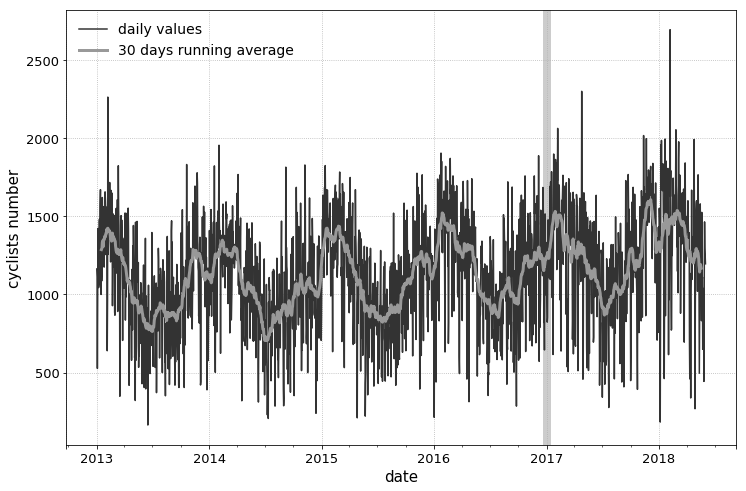

In [55]:
f, ax = plt.subplots(figsize=(12,8))

data.plot(ax=ax, color='0.2')

data.rolling(window=30, center=True).mean().plot(ax=ax, ls='-', lw=3, color='0.6')

ax.grid(ls=':')
ax.legend(['daily values','30 days running average'], frameon=False, fontsize=14)

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('cyclists number', fontsize=15);

ax.axvline('2017', color='0.8', lw=8, zorder=-1)

f.savefig('../figures/paper/cycling_counts_Tamaki_drive.png', dpi=200)
f.savefig('../figures/paper/cycling_counts_Tamaki_drive.jpeg', dpi=200)
f.savefig('../figures/paper/cycling_counts_Tamaki_drive.pdf', dpi=200)

### prepares the data for ingesting in fbprophet

In [56]:
data = data.rename({'Tamaki Drive, Filtered':'y'}, axis=1)

In [57]:
data.head()

,y
datetime,
2013-01-01,1163.0
2013-01-02,1112.0
2013-01-03,527.0
2013-01-04,1045.0
2013-01-05,1422.0


### splits the data into a training and test set, and returns these data frames in a format **fbprophet** can understand 

In [64]:
data_train, data_test = utils.prepare_data(data, 2017)

### instantiates, then fit the model to the training data 

The first step in **fbprophet** is to instantiate the model, it is there that you can set the `prior scales` for each component of your time-series, as well as the number of Fourier series to use to model the cyclic components.   

A general rule is that larger prior scales and larger number of Fourier series will make the model more flexible, but at the potential cost of generalisation: i.e. the model might [overfit](https://en.wikipedia.org/wiki/Overfitting), learning the noise (rather than the signal) in the training data, but 
    giving poor results when applied to yet unseen data (the test data)... setting these [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) can be more an art than a science ... 

In [65]:
m = Prophet(mcmc_samples=300, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [66]:
m.fit(data_train)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


### make the `future` dataframe 

In [67]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [68]:
future.head()

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


In [69]:
future.tail()

,ds
1973,2018-05-28
1974,2018-05-29
1975,2018-05-30
1976,2018-05-31
1977,2018-06-01


### forecast

In [70]:
forecast = m.predict(future)

### plots the `components` of the forecast (trend + cyclic component [yearly seasonality, weekly seasonality] at this stage)

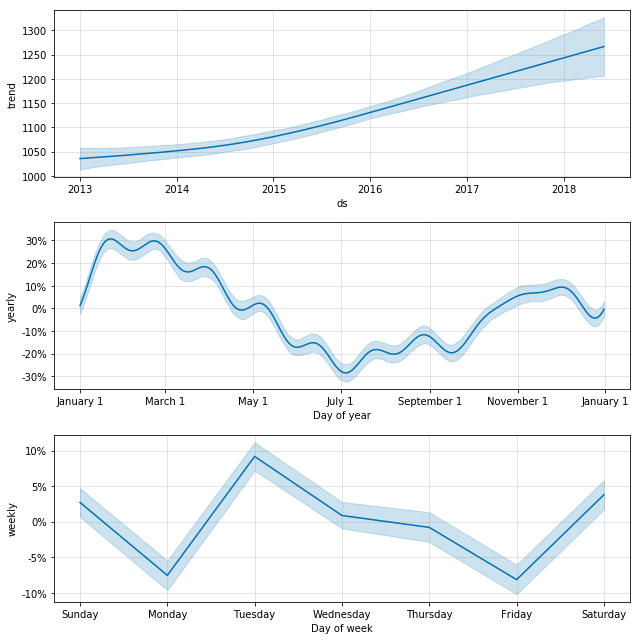

In [71]:
f = m.plot_components(forecast)

### put it all together with the actual observations 

In [72]:
verif = utils.make_verif(forecast, data_train, data_test)

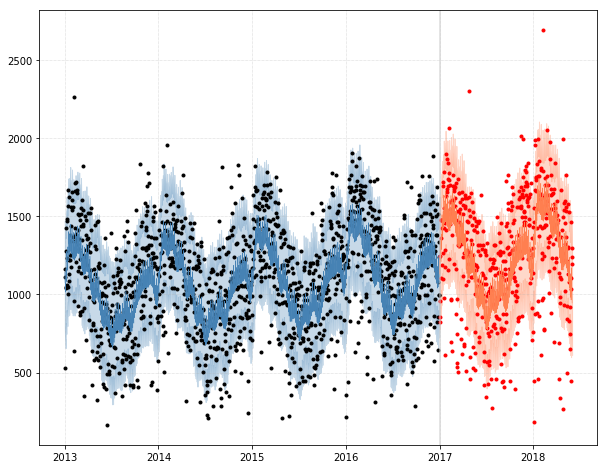

In [73]:
f = utils.plot_verif(verif)

### scatter plot, marginal distribution and correlation between observations and modelled / predicted values 

#### train set 

In [ ]:
utils.plot_joint_plot(verif.loc[:'2017',:], title='train set', fname='train_set_joint_plot_no_climate')

### test set 

In [ ]:
utils.plot_joint_plot(verif.loc['2017':,:], title='test set', fname='test_set_joint_plot_no_climate')

In [ ]:
verif.loc['2017':,['y','yhat']].corr()

### Mean Absolute Error (in number of cyclists)

In [ ]:
MAE(verif.y.values, verif.yhat.values)

## now incorporating the effects of the holidays 

In [ ]:
holidays_df = pd.DataFrame([], columns = ['ds','holiday'])

In [ ]:
ldates = []
lnames = []
for date, name in sorted(holidays.NZ(prov='AUK', years=np.arange(2013, 2018 + 1)).items()):
    ldates.append(date)
    lnames.append(name)

In [ ]:
ldates = np.array(ldates)
lnames = np.array(lnames)

In [ ]:
holidays_df.loc[:,'ds'] = ldates

In [ ]:
holidays_df.loc[:,'holiday'] = lnames

In [ ]:
holidays_df.tail()

In [ ]:
holidays_df.holiday.unique()

In [ ]:
def remove_obs(x): 
    return x.replace(' (Observed)','')

In [ ]:
holidays_df.loc[:,'holiday'] = holidays_df.loc[:,'holiday'].apply(remove_obs)

In [ ]:
m = Prophet(mcmc_samples=300, holidays=holidays_df, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [ ]:
m.fit(data_train)

In [ ]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [ ]:
forecast = m.predict(future)

In [ ]:
f = m.plot_components(forecast)

In [ ]:
verif = utils.make_verif(forecast, data_train, data_test)

In [ ]:
f = utils.plot_verif(verif)

In [ ]:
utils.plot_joint_plot(verif.loc[:'2017',:], title='train set', fname='train_set_joint_plot_no_climate_holidays')

In [ ]:
utils.plot_joint_plot(verif.loc['2017':,:], title='test set', fname='test_set_joint_plot_no_climate_holidays')

In [ ]:
(verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']).mean()

In [ ]:
f, ax = plt.subplots(figsize=(8,8))
sns.distplot((verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']), ax=ax)
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.text(0.05, 0.9, "Skewness = {:+4.2f}\nMedian = {:+4.2f}".\
        format(skew(verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']), (verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']).median()), \
        fontsize=14, transform=ax.transAxes)

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (test set)', fontsize=17)

f.savefig('../figures/paper/residuals_distribution_test_set_no_climate.jpeg', dpi=200)
f.savefig('../figures/paper/residuals_distribution_test_set_no_climate.pdf')

## incorporating the effects of weather conditions

#### temperature 

In [ ]:
temp = pd.read_csv('../data/weather/hourly/commute/temp_day.csv', index_col=0, parse_dates=True)

In [ ]:
temp = temp.loc[:,['Tmin(C)']]

In [ ]:
temp.columns = ['temp']

In [ ]:
temp.head()

#### rainfall 

In [ ]:
rain = pd.read_csv('../data/weather/hourly/commute/rain_day.csv', index_col=0, parse_dates=True)

In [ ]:
rain = rain.loc[:,['Amount(mm)']]

In [ ]:
rain.columns = ['rain']

In [ ]:
rain.head()

#### sunshine fraction 

In [ ]:
sun = pd.read_csv('../data/weather/hourly/commute/sun_day.csv', index_col=0, parse_dates=True)

In [ ]:
sun.columns = ['sun']

In [ ]:
sun.head()

#### wind 

In [ ]:
wind = pd.read_csv('../data/weather/hourly/commute/wind_day.csv', index_col=0, parse_dates=True)

In [ ]:
wind = wind.loc[:,['Speed(m/s)']]

In [ ]:
wind.columns = ['wind']

In [ ]:
wind.head()

### restrict to the available period 

In [ ]:
temp = temp.loc['2013':'2018-06-01',:]

In [ ]:
rain = rain.loc['2013':'2018-06-01',:]

In [ ]:
sun = sun.loc['2013':'2018-06-01',:]

In [ ]:
wind = wind.loc['2013':'2018-06-01',:]

### interpolate so that there are no missing values 

In [ ]:
temp = temp.interpolate(method='linear')

In [ ]:
rain = rain.interpolate(method='linear')

In [ ]:
sun = sun.interpolate(method='linear')

In [ ]:
wind = wind.interpolate(method='linear')

### adds the climate regressors to the data 

In [ ]:
data_with_regressors = add_regressor(data, temp, varname='temp')

In [ ]:
data_with_regressors = add_regressor(data_with_regressors, rain, varname='rain')

In [ ]:
data_with_regressors = add_regressor(data_with_regressors, sun, varname='sun')

In [ ]:
data_with_regressors = add_regressor(data_with_regressors, wind, varname='wind')

In [ ]:
data_with_regressors.head()

In [ ]:
data_with_regressors.tail()

### prepare the data and subsets (train and test set)

In [ ]:
data_train, data_test = utils.prepare_data(data_with_regressors, 2017)

In [ ]:
m = Prophet(mcmc_samples=300, holidays=holidays_df, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [ ]:
m.add_regressor('temp', prior_scale=0.5, mode='multiplicative')
m.add_regressor('rain', prior_scale=0.5, mode='multiplicative')
m.add_regressor('sun', prior_scale=0.5, mode='multiplicative')
m.add_regressor('wind', prior_scale=0.5, mode='multiplicative')

In [ ]:
m.fit(data_train)

In [ ]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [ ]:
futures = utils.add_regressor_to_future(future, [temp, rain, sun, wind])

In [ ]:
futures.head()

In [ ]:
forecast = m.predict(futures)

In [ ]:
f = m.plot(forecast)

In [ ]:
f = m.plot_components(forecast)

In [ ]:
verif = utils.make_verif(forecast, data_train, data_test)

In [ ]:
verif.head()

### clips the forecasts so that no value is negative (can't have a negative number of cyclists ! )

In [ ]:
verif.loc[:,'yhat'] = verif.yhat.clip_lower(0)

In [ ]:
verif.loc[:,'yhat_lower'] = verif.yhat_lower.clip_lower(0)

In [ ]:
f =  plot_verif(verif)

In [ ]:
utils.plot_joint_plot(verif.loc[:'2017',:], title='train set', fname='train_set_joint_plot_climate')

In [ ]:
utils.plot_joint_plot(verif.loc['2017':,:], title='test set', fname='test_set_joint_plot_no_climate')

### residuals distributions (test set)

In [ ]:
residuals = verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']

In [ ]:
f, ax = plt.subplots(figsize=(8,8))
sns.distplot(residuals, ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.set_title('Residuals distribution (test set)', fontsize=17)

ax.text(0.05, 0.85, "Skewness = {:+4.2f}\nMedian = {:+4.2f}\nMean = {:+4.2f}".\
        format(skew(residuals), residuals.median(), residuals.mean()), \
        fontsize=14, transform=ax.transAxes)

f.savefig('../figures/paper/residuals_distribution_test_set_climate.png', dpi=200)
f.savefig('../figures/paper/residuals_distribution_test_set_climate.jpeg', dpi=200)
f.savefig('../figures/paper/residuals_distribution_test_set_climate.pdf')

### plots the forecasts (`yhat`, dashed black line) and the observed values (`y`, solid grey line) in 6 months blocks

In [ ]:
f, axes = plt.subplots(nrows=3, figsize=(14,16), sharey=True)

ax = axes[0]

verif.loc['2017-01-01':'2017-06-30',['y']].plot(lw=5, ax=ax, color='0.7', ls='-')
verif.loc['2017-01-01':'2017-06-30',['yhat']].plot(lw=3, ax=ax, color='k', ls='--')

ax.grid(ls=':')
ax.legend(['observations','forecast'], fontsize=15)
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]
ax.set_ylabel('cyclists number', fontsize=15)
ax.set_xlabel('', fontsize=15)

ax.set_title('2017-01-01 to 2017-06-30', fontsize=18)

ax = axes[1]

verif.loc['2017-07-01':'2017-12-31',['y']].plot(lw=5, ax=ax, color='0.7', ls='-')
verif.loc['2017-07-01':'2017-12-31',['yhat']].plot(lw=3, ax=ax, color='k', ls='--')

ax.grid(ls=':')
ax.legend(['observations','forecast'], fontsize=15)
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]
ax.set_ylabel('cyclists number', fontsize=15)
ax.set_xlabel('', fontsize=15)

ax.set_title('2017-07-01 to 2017-12-31', fontsize=18)


ax = axes[2]

verif.loc['2018-01-01':'2018-06-30',['y']].plot(lw=5, ax=ax, color='0.7', ls='-')
verif.loc['2018-01-01':'2018-06-30',['yhat']].plot(lw=3, ax=ax, color='k', ls='--')

ax.grid(ls=':')
ax.legend(['observations','forecast'], fontsize=15)
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]
ax.set_ylabel('cyclists number', fontsize=15)
ax.set_xlabel('', fontsize=15)

ax.set_title('2018-01-01 to 2018-06-01', fontsize=18)

ax.set_xlim(['2018-01-01','2018-06-30'])

for ext in ['png','jpeg','pdf']: 
    f.savefig('../figures/paper/forecasts_obs_2017-08.{}'.format(ext), dpi=200)

### running correlations (over 90 days) between observed and modelled / predicted values, useful to identify when things go South

In [ ]:
corr = verif.loc[:,['y','yhat']].rolling(window=90, center=True).corr().iloc[0::2,1]

In [ ]:
corr.index = corr.index.droplevel(1)

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
corr.plot(ax=ax, lw=2, color='k')
ax.axhline(0.8, color='0.8', zorder=-1)
ax.axhline(0.6, color='0.8', zorder=-1)
ax.axvline('2017', color='k', zorder=-1)
ax.grid(ls=':')
ax.set_ylim([0.5, 0.9])
ax.set_xlabel('date', fontsize=15)
ax.set_ylabel("Pearson's R", fontsize=15)
ax.grid(ls=':')
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_yticks(np.arange(0.5, 1., 0.1)); 

ax.set_title('90 days running window correlation\nbetween observed and modelled / predicted values', fontsize=15)

f.savefig('../figures/paper/moving_corr.png', dpi=200)
f.savefig('../figures/paper/moving_corr.jpeg', dpi=200)
f.savefig('../figures/paper/moving_corr.pdf')

### correlation grouped by month, is there seasonality in the performance of the model ?

In [ ]:
corr_season_test = verif.loc['2017':,['y','yhat']].groupby(verif.loc['2017':,:].index.month).corr()
corr_season_train = verif.loc[:'2017',['y','yhat']].groupby(verif.loc[:'2017',:].index.month).corr()
corr_season = verif.loc[:,['y','yhat']].groupby(verif.loc[:,:].index.month).corr()

In [ ]:
f, ax = plt.subplots(figsize=(8,8))
corr_season_train.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12, label='train set', ls='-', color='k')
corr_season_test.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12, label='test set', ls='--', color='k')
# corr_season.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12)

ax.legend(fontsize=17, loc=3)

ax.set_xticks(range(1, 13))
ax.set_xticklabels(list('JFMAMJJASOND'))
ax.set_xlabel('month', fontsize=15)
ax.set_ylabel("Pearson's R", fontsize=15)
ax.grid(ls=':')
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('correlation per month', fontsize=17)

f.savefig('../figures/paper/correlation_obs_pred_per_month.png', dpi=200)
f.savefig('../figures/paper/correlation_obs_pred_per_month.jpeg', dpi=200)
f.savefig('../figures/paper/correlation_obs_pred_per_month.pdf')

### plot the contribution of the different climate variables to the response variable (in percentage of the trend component, as we chose a multiplicative model)

In [ ]:
f  = plot_verif_component(verif, component = 'sun')

In [ ]:
f  = plot_verif_component(verif, component = 'rain')

In [ ]:
f  = plot_verif_component(verif, component = 'wind')

### plots the combined contribution of the climate extra-regressors

In [ ]:
f = plot_verif_component(verif, component = 'extra_regressors_multiplicative')

### zoom in on the post 2016 period (test set)

In [ ]:
verif.loc['2016-12-31':,'extra_regressors_multiplicative'].abs().mean()

In [ ]:
f = plot_verif_component(verif.loc['2016-12-31':,:], component = 'extra_regressors_multiplicative')

In [ ]:
f = plot_verif_component(verif.loc['2016-12-31':,:], component = 'rain')

In [ ]:
f = plot_verif_component(verif.loc['2016-12-31':,:], component = 'wind')